In [2]:
### CELL 1: IMPORTS & SETUP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import random

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# --- CONFIGURATION ---
IMG_SIZE = (224, 224)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
BATCH_SIZE = 32
NUM_CLASSES = 4
CLASS_LABELS = ['glioma', 'meningioma', 'notumor', 'pituitary']
EPOCHS = 20
LR = 0.001
PATIENCE = 5

# --- IMPORTANT: DEFINE ATTENTION BLOCK HERE ---
@tf.keras.utils.register_keras_serializable()
def channel_attention(input_feature, ratio=8):
    channel_axis = -1
    channel = input_feature.shape[channel_axis]
    x = layers.GlobalAveragePooling2D()(input_feature)
    x = layers.Dense(channel // ratio, activation='relu')(x)
    x = layers.Dense(channel, activation='sigmoid')(x)
    x = layers.Reshape((1, 1, channel))(x)
    return layers.Multiply()([input_feature, x])

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Brain_Tumor_MRI_Dataset'

Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Brain_Tumor_MRI_Dataset'

# Define paths to the pre-split Training and Testing folders
TRAIN_DIR = os.path.join(DRIVE_PROJECT_PATH, 'Training')
TEST_DIR = os.path.join(DRIVE_PROJECT_PATH, 'Testing')

print(f"Loading training data from: {TRAIN_DIR}")
print(f"Loading testing data from: {TEST_DIR}")

Mounted at /content/drive
Loading training data from: /content/drive/MyDrive/Brain_Tumor_MRI_Dataset/Training
Loading testing data from: /content/drive/MyDrive/Brain_Tumor_MRI_Dataset/Testing


In [5]:
# --- NEW: Create a directory to save our models ---
CHECKPOINT_DIR = os.path.join(DRIVE_PROJECT_PATH, 'model_checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True) # Creates the folder if it doesn't exist

print(f"Loading training data from: {TRAIN_DIR}")
print(f"Loading testing data from: {TEST_DIR}")
print(f"Saving model checkpoints to: {CHECKPOINT_DIR}")



Loading training data from: /content/drive/MyDrive/Brain_Tumor_MRI_Dataset/Training
Loading testing data from: /content/drive/MyDrive/Brain_Tumor_MRI_Dataset/Testing
Saving model checkpoints to: /content/drive/MyDrive/Brain_Tumor_MRI_Dataset/model_checkpoints


In [7]:
import tensorflow as tf

### 4. DATA LOADING & PREPARATION (THE CORRECTED STEP)
# It loads images directly from the folders (no CSV needed).
print("--- Loading and preprocessing data from folders ---")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical', # Creates one-hot encoded labels
    class_names=CLASS_LABELS,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_LABELS,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False # Do not shuffle test data
)

print("\nData pipelines created successfully.")
print(f"Found class names: {train_dataset.class_names}")

--- Loading and preprocessing data from folders ---
Found 4614 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.

Data pipelines created successfully.
Found class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
### 5. CALCULATE CLASS WEIGHTS
print("--- Calculating Class Weights ---")
# Get all labels from the training dataset
y_train_labels_int = []
# Iterate through the dataset to get all labels
for images, labels in train_dataset:
    y_train_labels_int.extend(np.argmax(labels.numpy(), axis=1))

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels_int),
    y=y_train_labels_int
)
# Keras needs this as a dictionary {class_index: weight}
class_weights = dict(zip(range(len(class_weights_array)), class_weights_array))
print(f"Class Weights: {class_weights}")

--- Calculating Class Weights ---


KeyboardInterrupt: 

In [8]:
### 6. CONFIGURE DATASET FOR PERFORMANCE
# Use prefetching to speed up training
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
import random # Import the random module
import shutil # Import the shutil module for file operations

### 3.5. REDUCE TRAINING DATASET (Robust Version)
# This block ensures exactly 250 files are moved to 'Training_Excluded'
FILES_TO_REMOVE = 250
EXCLUDED_DIR = os.path.join(DRIVE_PROJECT_PATH, 'Training_Excluded')

if not os.path.exists(EXCLUDED_DIR):
    os.makedirs(EXCLUDED_DIR)

print(f"\n--- Ensuring {FILES_TO_REMOVE} files are excluded per class ---")

for class_name in CLASS_LABELS:
    src_class_dir = os.path.join(TRAIN_DIR, class_name)
    dst_class_dir = os.path.join(EXCLUDED_DIR, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)

    if os.path.exists(src_class_dir):
        # 1. Check how many files are ALREADY in the excluded folder
        existing_excluded = len(os.listdir(dst_class_dir))

        # 2. Calculate how many MORE we need to move
        files_needed_to_move = FILES_TO_REMOVE - existing_excluded

        if files_needed_to_move > 0:
            print(f"{class_name}: Found {existing_excluded} excluded. Moving {files_needed_to_move} more...")

            # Get list of current training files
            current_train_files = os.listdir(src_class_dir)

            if len(current_train_files) >= files_needed_to_move:
                # Randomly select files to move
                files_to_move = random.sample(current_train_files, files_needed_to_move)
                for file_name in files_to_move:
                    shutil.move(os.path.join(src_class_dir, file_name), os.path.join(dst_class_dir, file_name))
                print(f"   -> Success: Moved {files_needed_to_move} files.")
            else:
                print(f"   -> Warning: Not enough files in training to move.")
        else:
            print(f"{class_name}: Already has {existing_excluded} excluded files. Skipping.")
    else:
         print(f"Skipping {class_name}: Source directory not found.")



--- Ensuring 250 files are excluded per class ---
glioma: Already has 250 excluded files. Skipping.
meningioma: Already has 250 excluded files. Skipping.
notumor: Already has 250 excluded files. Skipping.
pituitary: Already has 250 excluded files. Skipping.


In [9]:
### COUNT FILES IN EACH CLASS
print("\n--- Counting Files in Dataset ---")

print("Training Data:")
for class_name in CLASS_LABELS:
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_path): # Check if directory exists
        num_files = len(os.listdir(class_path))
        print(f"- {class_name}: {num_files} files")
    else:
        print(f"- {class_name}: Directory not found!")

print("\nTesting Data:")
for class_name in CLASS_LABELS:
    class_path = os.path.join(TEST_DIR, class_name)
    if os.path.isdir(class_path): # Check if directory exists
        num_files = len(os.listdir(class_path))
        print(f"- {class_name}: {num_files} files")
    else:
        print(f"- {class_name}: Directory not found!")


--- Counting Files in Dataset ---
Training Data:
- glioma: 972 files
- meningioma: 1090 files
- notumor: 1345 files
- pituitary: 1207 files

Testing Data:
- glioma: 300 files
- meningioma: 306 files
- notumor: 405 files
- pituitary: 300 files



--- Visualizing Data Distribution ---


/tmp/ipython-input-1312108055.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="viridis")
/tmp/ipython-input-1312108055.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), palette="viridis")


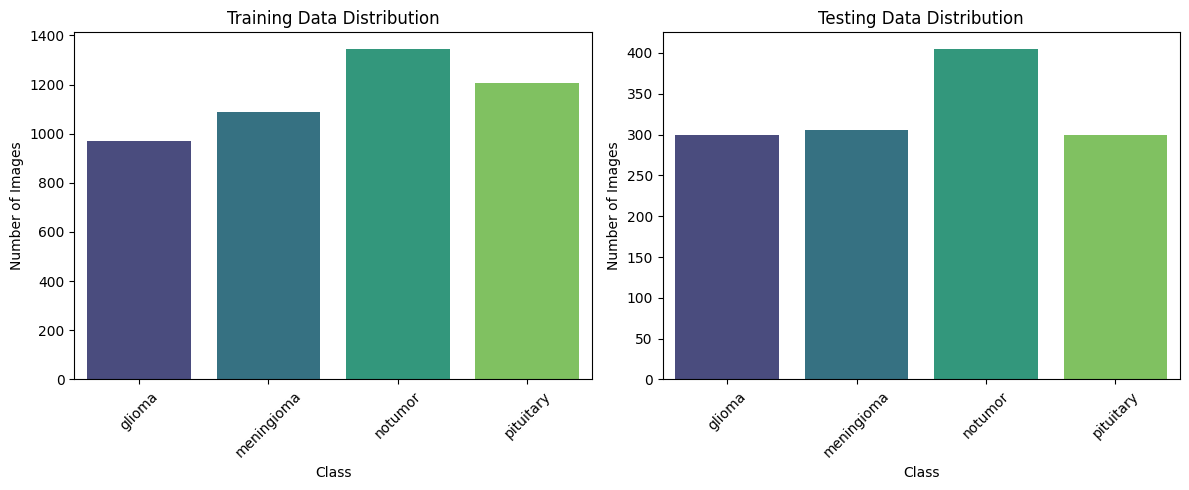

In [10]:
# --- NEW: Plot Data Distribution ---
print("\n--- Visualizing Data Distribution ---")

# Define train_counts and test_counts by re-counting files
train_counts = {}
for class_name in CLASS_LABELS:
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_path):
        train_counts[class_name] = len(os.listdir(class_path))
    else:
        print(f"Warning: Training directory for {class_name} not found!")

test_counts = {}
for class_name in CLASS_LABELS:
    class_path = os.path.join(TEST_DIR, class_name)
    if os.path.isdir(class_path):
        test_counts[class_name] = len(os.listdir(class_path))
    else:
        print(f"Warning: Testing directory for {class_name} not found!")


plt.figure(figsize=(12, 5))

# Plot Training Data
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="viridis")
plt.title("Training Data Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)

# Plot Testing Data
plt.subplot(1, 2, 2)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), palette="viridis")
plt.title("Testing Data Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show() # This will display the bar charts


Training ResNet50...
Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1788s 12s/step - accuracy: 0.7283 - loss: 0.6556 - val_accuracy: 0.8787 - val_loss: 0.3064
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.9023 - loss: 0.2537 - val_accuracy: 0.9092 - val_loss: 0.2307
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - accuracy: 0.9293 - loss: 0.1964 - val_accuracy: 0.8924 - val_loss: 0.2724
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.9353 - loss: 0.1665 - val_accuracy: 0.9024 - val_loss: 0.3049
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 26s 179ms/step - accuracy: 0.9479 - loss: 0.1298 - val_accuracy: 0.9237 - val_loss: 0.2223
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.9643 - loss: 0.1000 - val_accuracy: 0.9252 - val_loss: 0.2176
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 38s 170ms/step - accuracy: 0.9655 - loss: 0.0911 - val_accuracy: 0.9222 - val_loss: 0.2557
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accu

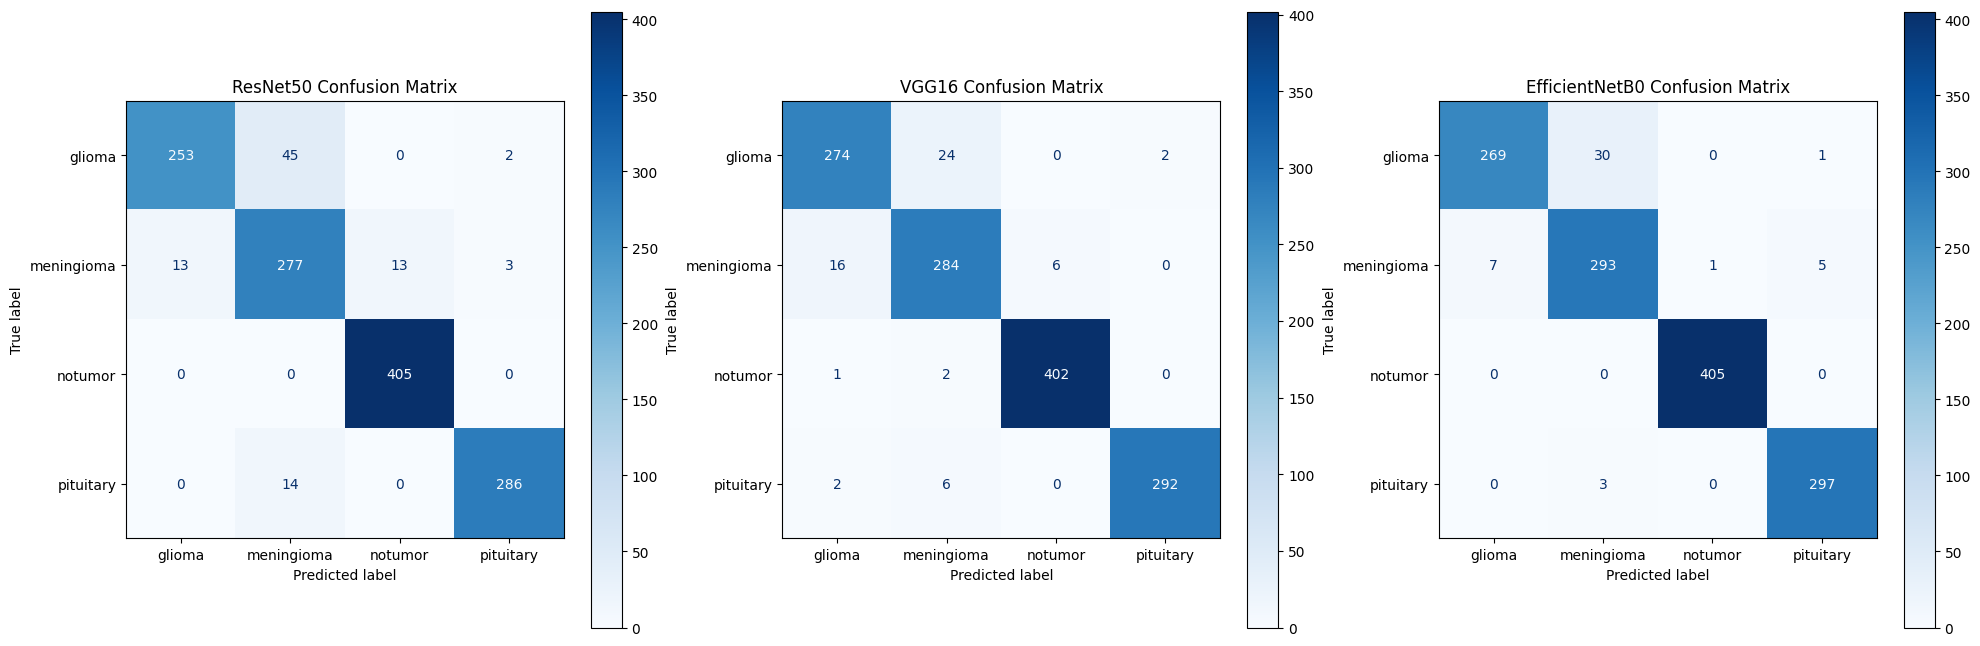

In [12]:
### CELL 3: TRAIN SINGLE MODELS
def build_model(base_model_fn, preprocess_fn, model_name, reduction_ratio=8):
    base_model = base_model_fn(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = layers.Input(shape=INPUT_SHAPE, name=f"{model_name}_input")
    x = layers.Lambda(preprocess_fn, name='preprocessing')(inputs)
    x = base_model(x, training=False)
    x = channel_attention(x, ratio=reduction_ratio) # ATTENTION ADDED HERE
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs, name=model_name)
    model.compile(optimizer=keras.optimizers.Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create Models
reduction = 4
model_resnet = build_model(ResNet50, resnet_preprocess, "ResNet50", reduction_ratio=reduction)
model_vgg = build_model(VGG16, vgg_preprocess, "VGG16", reduction_ratio=reduction)
model_eff = build_model(EfficientNetB0, efficientnet_preprocess, "EfficientNetB0", reduction_ratio=reduction)

models_map = {"ResNet50": model_resnet, "VGG16": model_vgg, "EfficientNetB0": model_eff}
y_true = []
for _, labels in test_dataset: y_true.extend(np.argmax(labels.numpy(), axis=1))

plt.figure(figsize=(24, 8))
early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

for i, (name, model) in enumerate(models_map.items()):
    print(f"\nTraining {name}...")
    ckpt_path = os.path.join(CHECKPOINT_DIR, f"{name}_best.keras")
    ckpt = ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss', mode='min')

    model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS,
              #class_weight=class_weights
               callbacks=[ckpt, early_stop], verbose=1)

    # Load Best and Evaluate
    custom_objs = {'channel_attention': channel_attention, 'preprocess_input': resnet_preprocess}
    # Note: preprocess_input key is generic, might need adjustment per model if strict,
    # but 'restore_best_weights=True' in EarlyStopping usually handles the best model in memory automatically.

    preds = np.argmax(model.predict(test_dataset), axis=1)
    cm = confusion_matrix(y_true, preds)
    ax = plt.subplot(1, 3, i+1)
    ConfusionMatrixDisplay(cm, display_labels=CLASS_LABELS).plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(f"{name} Confusion Matrix")
plt.show()


--- Building Parallel Ensemble (VGG16 + EfficientNetB0) ---
Ensemble Summary:


Model: "Ensemble_VGG_EffNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_preprocess      │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ effnet_preprocess   │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16_base          │ (None, 7, 7, 512) │ 14,714,688 │ vgg_preprocess[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ effnet_base         │ (None, 7, 7,      │  4,049,571 │ effnet_preproces… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16_base[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ effnet_base[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     65,664 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 320)       │    409,920 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 512)       │     66,048 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1280)      │    410,880 │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1, 1, 512) │          0 │ dense_33[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_11          │ (None, 1, 1,      │          0 │ dense_35[0][0]    │
│ (Reshape)           │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_10         │ (None, 7, 7, 512) │          0 │ vgg16_base[0][0], │
│ (Multiply)          │                   │            │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_11         │ (None, 7, 7,      │          0 │ effnet_base[0][0… │
│ (Multiply)          │ 1280)             │            │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_pool            │ (None, 512)       │          0 │ multiply_10[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ effnet_pool         │ (None, 1280)      │          0 │ multiply_11[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_featur… │ (None, 1792)      │          0 │ vgg_pool[0][0],   │
│ (Concatenate)       │                   │            │ effnet_pool[0][0

 Total params: 20,636,839 (78.72 MB)

 Trainable params: 1,872,580 (7.14 MB)

 Non-trainable params: 18,764,259 (71.58 MB)


Stage 1: Training Head...
Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 89s 435ms/step - accuracy: 0.7450 - loss: 0.7881 - val_accuracy: 0.8856 - val_loss: 0.3104
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 35s 240ms/step - accuracy: 0.9132 - loss: 0.2431 - val_accuracy: 0.9176 - val_loss: 0.2247
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 36s 248ms/step - accuracy: 0.9444 - loss: 0.1565 - val_accuracy: 0.9237 - val_loss: 0.1956
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 35s 241ms/step - accuracy: 0.9463 - loss: 0.1299 - val_accuracy: 0.9184 - val_loss: 0.2416
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 35s 244ms/step - accuracy: 0.9602 - loss: 0.1035 - val_accuracy: 0.9329 - val_loss: 0.1660
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 36s 243ms/step - accuracy: 0.9759 - loss: 0.0663 - val_accuracy: 0.9420 - val_loss: 0.1720
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - accuracy: 0.9727 - loss: 0.0699 - val_accuracy: 0.9535 - val_loss: 0.1337
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 36s 245ms/step -

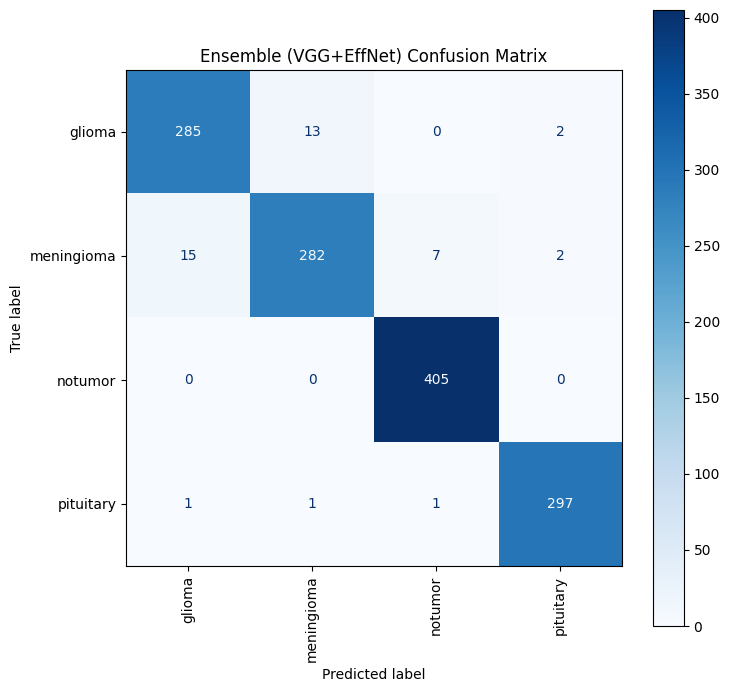

In [16]:
### CELL 4: TRAIN ENSEMBLE MODEL (VGG16 + EFFICIENTNETB0) WITH MANUAL WEIGHTS

# --- FIX: Manually download EfficientNetB0 weights ---
# This bypasses the 403 Forbidden error
import os
if not os.path.exists('efficientnetb0_notop.h5'):
    print("Downloading EfficientNetB0 weights manually...")
    !wget https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5 -O efficientnetb0_notop.h5

print("\n--- Building Parallel Ensemble (VGG16 + EfficientNetB0) ---")
inputs = layers.Input(shape=INPUT_SHAPE, name="input_image")

# --- Branch 1: VGG16 ---
# VGG weights usually download fine, but if this fails too, we can apply the same fix
vgg_base = VGG16(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', name="vgg16_base")
vgg_base.trainable = False
x1 = layers.Lambda(vgg_preprocess, name='vgg_preprocess')(inputs)
x1 = vgg_base(x1, training=False)
x1 = channel_attention(x1, ratio=4)
x1 = layers.GlobalAveragePooling2D(name='vgg_pool')(x1)

# --- Branch 2: EfficientNetB0 ---
# UPDATED: We use the local file path 'efficientnetb0_notop.h5' instead of 'imagenet'
eff_base = EfficientNetB0(input_shape=INPUT_SHAPE, include_top=False, weights='efficientnetb0_notop.h5', name="effnet_base")
eff_base.trainable = False
x2 = layers.Lambda(efficientnet_preprocess, name='effnet_preprocess')(inputs)
x2 = eff_base(x2, training=False)
x2 = channel_attention(x2, ratio=4)
x2 = layers.GlobalAveragePooling2D(name='effnet_pool')(x2)

# --- Merge & Classifier ---
merged = layers.concatenate([x1, x2], name="concatenate_features")
x = layers.Dense(512, activation='relu', name='head_dense')(merged)
x = layers.Dropout(0.5, name='head_dropout')(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='head_output')(x)

ensemble_model = Model(inputs, outputs, name="Ensemble_VGG_EffNet")
ensemble_model.compile(optimizer=keras.optimizers.Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])

print("Ensemble Summary:")
ensemble_model.summary()

# --- Train Stage 1 (Head Only) ---
print("\nStage 1: Training Head...")
ckpt_path = os.path.join(CHECKPOINT_DIR, "ensemble_vgg_eff_best.keras")
ckpt = ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss', mode='min')

history1 = ensemble_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    #class_weight=class_weights,
    callbacks=[ckpt, early_stop],
    verbose=1
)

# --- Train Stage 2 (Fine-Tuning) ---
print("\nStage 2: Fine-Tuning...")
vgg_base.trainable = True
eff_base.trainable = True

# Unfreeze VGG from block 5
set_trainable = False
for layer in vgg_base.layers:
    if layer.name == 'block5_conv1': set_trainable = True
    layer.trainable = set_trainable
print("VGG16: Unfrozen from block5_conv1")

# Unfreeze EfficientNet from block 7
set_trainable = False
for layer in eff_base.layers:
    if layer.name == 'block7a_expand_conv': set_trainable = True
    layer.trainable = set_trainable
print("EfficientNetB0: Unfrozen from block7a_expand_conv")

# Recompile with Low LR
ensemble_model.compile(optimizer=keras.optimizers.Adam(LR/100), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = ensemble_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20 + 10,
    initial_epoch=history1.epoch[-1],
    #class_weight=class_weights,
    callbacks=[ckpt, early_stop],
    verbose=1
)

# --- Evaluate ---
print("\nEvaluating Ensemble...")
custom_objs = {
    'channel_attention': channel_attention,
    'vgg_preprocess': vgg_preprocess,
    'efficientnet_preprocess': efficientnet_preprocess
}

try:
    best_ensemble = tf.keras.models.load_model(ckpt_path, custom_objects=custom_objs)
    print("Loaded best model from disk.")
except Exception as e:
    print(f"Could not load best model ({e}), using current model.")
    best_ensemble = ensemble_model

preds = np.argmax(best_ensemble.predict(test_dataset), axis=1)
# y_true needs to be redefined here if Cell 3 wasn't run recently, but assuming it was:
# If y_true is missing, uncomment the next two lines:
# y_true = []
# for _, labels in test_dataset: y_true.extend(np.argmax(labels.numpy(), axis=1))

cm = confusion_matrix(y_true, preds)

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LABELS)
disp.plot(ax=plt.gca(), cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Ensemble (VGG+EffNet) Confusion Matrix")
plt.show()